In [113]:
# Generic stuff

# Numerical stuff
import numpy as np
from skimage import measure
from scipy import misc
import scipy.signal as scis

# Viz or image stuff
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import cv2

# Astronomy stuff
from astropy.io import fits
from properimage import single_image
from properimage.tests import simtools
from properimage import plot
from astropy.modeling.functional_models import Gaussian2D

# Heavy computation stuff
from numba import jit

In [10]:
def debayer(hdu):
    image = hdu.data
    header = hdu.header
    if len(image.shape) == 2 and not ("BAYERPAT" in header):
        print("B&W mode...")
    elif len(image.shape) == 3:
        print("RGB mode...")
    elif len(image.shape) == 2 and "BAYERPAT" in header:
        print("debayering...")
        debay = header["BAYERPAT"]
        # test bayer type and debayer
        cv_debay = debay[3] + debay[2]
        if cv_debay == "BG":
            rgb_image = cv2.cvtColor(image, cv2.COLOR_BAYER_BG2RGB)
        elif cv_debay == "GB":
            rgb_image = cv2.cvtColor(image, cv2.COLOR_BAYER_GB2RGB)
        elif cv_debay == "RG":
            rgb_image = cv2.cvtColor(image, cv2.COLOR_BAYER_RG2RGB)
        elif cv_debay == "GR":
            rgb_image = cv2.cvtColor(image, cv2.COLOR_BAYER_GR2RGB)
        else:
            raise ValueError("this debayer option not support")
        # convert cv2 order to classic order:
        image = rgb_image #np.rollaxis(rgb_image, 2, 0)
    return image

debayering...


(-0.5, 5471.5, 3647.5, -0.5)

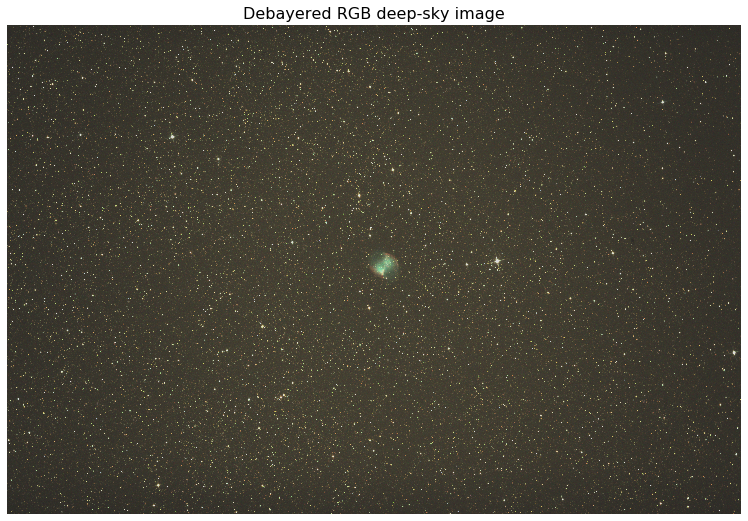

In [19]:
# Open image ans show stuff
img_path = './data/Light_M27.fits'
hdu_list = fits.open(img_path)
hdu = hdu_list[0]
image = debayer(hdu)

# Now show
fig, ax = plt.subplots(figsize=(16,9))
ax.set_title("Debayered RGB deep-sky image")
ax.imshow(image/image.max())
ax.axis('off')

In [23]:
def gen_psf_pattern():
    frames = []
    for theta in [0, 45, 105, 150]:
        N = 512  # side
        X_FWHM = 5 + 5.5*theta/180
        Y_FWHM = 5
        t_exp = 5
        max_fw = max(X_FWHM, Y_FWHM)
        x = np.random.randint(low=6*max_fw, high=N-6*max_fw, size=80)
        y = np.random.randint(low=6*max_fw, high=N-6*max_fw, size=80)
        xy = [(x[i], y[i]) for i in range(80)]
        SN =  30. # SN para poder medir psf
        weights = list(np.linspace(10, 1000., len(xy)))
        m = simtools.delta_point(N, center=False, xy=xy, weights=weights)
        im = simtools.image(m, N, t_exp, X_FWHM, Y_FWHM=Y_FWHM, theta=theta,
                            SN=SN, bkg_pdf='gaussian')
        frames.append(im+100.)
    frame = np.zeros((1024, 1024))
    for j in range(2):
        for i in range(2):
            frame[i*512:(i+1)*512, j*512:(j+1)*512] = frames[i+2*j]
    return frame

mean = 0, std = 1.1570077460537824, b = 34.71023238161347, SN = 30.0
mean = 0, std = 0.8916017522659099, b = 26.748052567977297, SN = 30.0
mean = 0, std = 0.9666449821703474, b = 28.999349465110424, SN = 30.0
mean = 0, std = 0.5987545697685713, b = 17.96263709305714, SN = 30.0


(-0.5, 1023.5, 1023.5, -0.5)

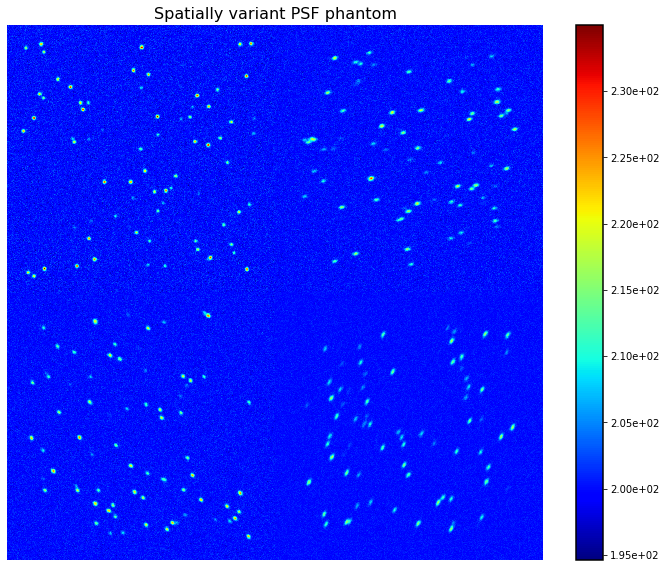

In [28]:
# Now show
image = gen_psf_pattern()
fig, ax = plt.subplots(figsize=(12,12))
ax.set_title("Spatially variant PSF phantom")
heatmap = ax.imshow(image, cmap='jet')
plt.colorbar(heatmap, format=FormatStrFormatter('%.2e'), shrink=0.82)
ax.axis('off')

updating stamp shape to (25,25)
(111, 111) (625, 111)
cleaning... 
Projected psf model of size (25, 25) from the 4 first eigenvectors
Reconstructing the psf map of size (1024, 1024) from 4 coefficients


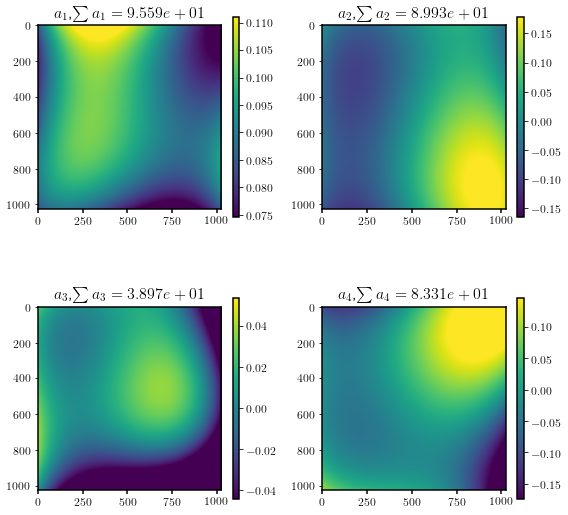

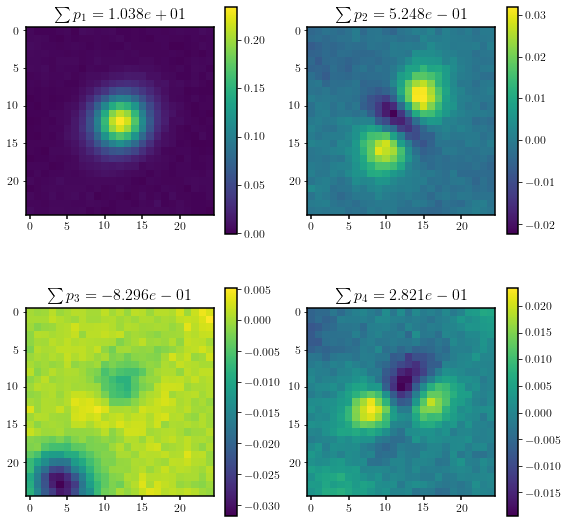

In [47]:
# Ok lets start doin the stuff
with single_image.SingleImage(image, smooth_psf=False) as sim:
    a_fields, psf_basis = sim.get_variable_psf(inf_loss=0.15)
    x, y = sim.get_afield_domain()
print("Projected psf model of size {} from the {} first eigenvectors".format(
      psf_basis[0].shape, len(psf_basis)))
print("Reconstructing the psf map of size {} from {} coefficients".format(a_fields[0](x, y).shape, len(a_fields)))
plot.plot_afields(a_fields=a_fields, x=x, y=y, nbook=True)
plot.plot_psfbasis(psf_basis=psf_basis, nbook=True)

In [140]:
def gen_gaussian_patch(size=21, fwhm=[3, 1], theta=3.*np.pi/4., debug=False):
    """
        fwhm = 2*np.sqrt(2*np.log(2))*sigma
    """
    #define mesh
    Y,X=np.meshgrid(0.5+np.linspace(0,size-1,size),0.5+np.linspace(0,size-1,size))
    xvec = np.array([np.reshape(X,X.size),np.reshape(Y,Y.size)])
    
    #define a 2D rotation matrix:
    def GetRotMat(theta):
      return np.array([[np.cos(theta),-np.sin(theta)],
        [np.sin(theta),np.cos(theta)]])
    Mrot = GetRotMat(theta)
    #define anisotropic and rotated gaussian
    Sigma = np.dot(Mrot,np.dot(np.diag(fwhm/np.sqrt(8*np.log(2)))**2,Mrot.T))
    mu = np.array([[size/2],[size/2]])
    coef = 1/np.sqrt(np.power(2*np.pi,2)*np.linalg.det(Sigma))
    
    #2-dimensional gaussian pdf
    test=np.dot(np.linalg.inv(Sigma),xvec-mu)
    K=coef * np.exp(-0.5* np.sum(test*(xvec-mu),0))
    K=np.reshape(K,X.shape)/K.sum()
    
    #Normalize
    K/=K.sum()
    KT=K[::-1,::-1]
    
    #Plot
    if debug:
        fig, ax = plt.subplots(1,figsize=(8,8))
        ax.set_title("2D gaussian kernel")
        heatmap = ax.imshow(K, cmap='jet')
        plt.colorbar(heatmap, format=FormatStrFormatter('%.2e'), shrink=0.82)
    return K

fwhm = [20, 50]
patch = gen_gaussian_patch(size=128, fwhm=fwhm, theta=0, debug=True)
print("Value close to maximum is {}".format(patch[int(patch.shape[0]/2),int(patch.shape[1]/2)]))
print("Value close to fwhm is {}".format(patch[int(patch.shape[0]/2+fwhm[0]/2), int(patch.shape[1]/2)]))
print("Value close to fwhm is {}".format(patch[int(patch.shape[0]/2), int(patch.shape[1]/2+fwhm[1]/2)]))

SyntaxError: invalid syntax (<ipython-input-140-cde3adc0f584>, line 39)

[[64.]
 [64.]] [[ 7.11994450e+02 -2.12550672e-15]
 [-2.22300604e-15  2.12330450e+01]] {'fwhms': array([1676.61880224,   50.        ]), 'ellipticity': 0.8273097429029266, 'angle_degree': 0.0}


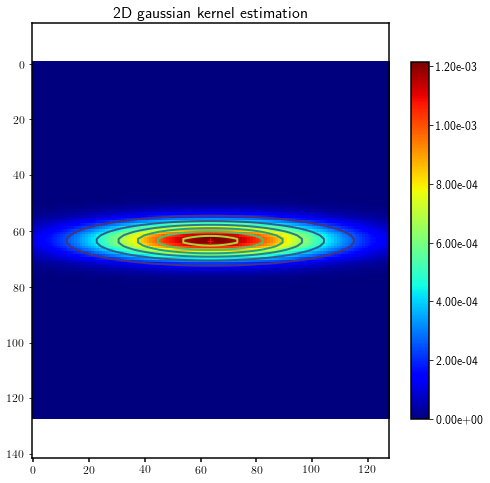

In [122]:
# Use moment estimate method to find ellipticity and fwhm
def compute_metrics(patch, debug=False):
    # gen 2 by N matrix with 2d point coordinates. 0,0 is
    # the top left corner of top left pixel
    X,Y=np.meshgrid(0.5+np.linspace(0,patch.shape[0]-1,patch.shape[0]),
                    0.5+np.linspace(0,patch.shape[1]-1,patch.shape[1]))
    xvec = np.array([np.reshape(X,X.size),np.reshape(Y,Y.size)])
    weighting = patch.flatten()/patch.sum()

    #Estimate mu
    mu_est = np.dot(xvec, weighting).reshape(2,1)

    #Estimate Sigma, while weighting each pixel
    xvec_cent = xvec-mu_est
    sigma_est = np.dot(weighting*xvec_cent, xvec_cent.T)
    
    # longest and shortest semi axis
    e,v = np.linalg.eig(sigma_est)
    idx = e.argsort() #sort values from lowest to highest
    f=1/np.sqrt(e)
    a=f[idx[0]]
    b=f[idx[1]]

    if debug:
        #Generate predefined meshgrid
        x = np.linspace(0, patch.shape[0], 100)
        y = np.linspace(0, patch.shape[1], 100)
        Xax, Yax = np.meshgrid(x,y)
        xvec = np.array([np.reshape(Xax,Xax.size),np.reshape(Yax,Yax.size)])

        #plot contour of 2-dimensional gaussian pdf
        # WARN: matplotlib show pixel 0 center at 0,0, not 0.5,0.5 as in out case
        coef = 1/np.sqrt(np.power(2*np.pi,2)*np.linalg.det(sigma_est))
        test=np.dot(np.linalg.inv(sigma_est), xvec-mu_est)
        gauss_est = coef * np.exp(-0.5* np.sum(test*(xvec-mu_est),0))
        Xax = Xax-0.5
        Yax = Yax-0.5

        fig, ax = plt.subplots(1,figsize=(8,8))
        ax.set_title("2D gaussian kernel estimation")
        heatmap = ax.imshow(patch, cmap='jet')
        plt.colorbar(heatmap, format=FormatStrFormatter('%.2e'), shrink=0.82)
        ax.contour(Xax,Yax,np.reshape(gauss_est, Xax.shape))
        ax.plot(mu_est[0]-0.5, mu_est[1]-0.5, 'r+')
        ax.axis('equal')
        
    # Now compute metrics
    metrics = {}
    g2d = Gaussian2D(amplitude=1, x_mean=mu_est[0], y_mean=mu_est[0], cov_matrix=sigma_est)
    metrics["fwhms"] = 2*np.sqrt(2*np.log(2))*e
    metrics["ellipticity"] = (a-b)/a
    metrics["angle_degree"] = np.degrees(np.arctan2(v[1,idx[1]],v[0,idx[1]]))

    return mu_est, sigma_est, metrics, g2d
mu_est, sigma_est, metrics, g2d = compute_metrics(patch, debug=True)
print(mu_est, sigma_est, metrics)

In [ ]:




"""
  import dataset, and convert to b&w fp32 by summing channels
"""
xbar = misc.face()
xbar = np.sum(xbar.astype(np.float64),axis=2)
dyn = xbar.ptp()
#Plot
plt.figure(0)
plt.title("Original image")
plt.imshow(xbar,interpolation="nearest", cmap=plt.cm.gray)
plt.axis("off")

"""
  Define a 2D, non axis aligned gaussian kernel, and its time reversed version
"""
#define mesh
sizeK = 11 # must be odd
X,Y=np.meshgrid(np.linspace(-1,1,sizeK),np.linspace(-1,1,sizeK))
xvec = np.array([np.reshape(X,X.size),np.reshape(Y,Y.size)])
#define a 2D rotation matrix:
def GetRotMat( theta ):
  return np.array([[np.cos(theta),-np.sin(theta)],
    [np.sin(theta),np.cos(theta)]])
Mrot = GetRotMat( 3.*np.pi/4. )
#define anisotropic and rotated gaussian
Sigma = np.dot(Mrot,np.dot(np.diag([0.15,1]),Mrot.T))
mu = np.array([[0],[0]])
coef = 1/np.sqrt(np.power(2*np.pi,2)*np.linalg.det(Sigma))
#2-dimensional gaussian pdf
test=np.dot(np.linalg.inv(Sigma),xvec-mu)
K=coef * np.exp(-0.5* np.sum(test*(xvec-mu),0))
K=np.reshape(K,X.shape)/K.sum()
#Normalize
K/=K.sum()
KT=K[::-1,::-1]
#Plot
plt.figure(1,figsize=(5,5))
plt.title("2D gaussian kernel")
plt.imshow(K)
plt.axis("off")

"""
  Perform convolution with gaussian kernel + add noise
"""
blurred=scis.convolve2d(xbar, K, mode='same', boundary='symm', fillvalue=0)
stddev = 10
blurred=np.random.poisson(blurred.astype(np.int64)).astype(np.float64)
#blurred += np.random.normal(0,stddev,blurred.shape)
psnrBlurred = measure.compare_psnr(xbar, blurred, dynamic_range=dyn)
ssimBlurred = measure.compare_ssim(xbar, blurred, win_size=5, dynamic_range=dyn)
#Plot
plt.figure(2)
plt.title("Blurred image, PSNR= "+("%.2f" % psnrBlurred)+
  " SSIM= "+("%.2f" % ssimBlurred))
plt.imshow(blurred, interpolation="nearest", cmap=plt.cm.gray)
plt.axis("off")


"""
  Perform Richardson-Lucy algorithm
"""
nbiter = 25
xk=blurred.copy()
for i in range(nbiter):
    estim = scis.convolve2d(xk, K,
      mode='same', boundary='symm', fillvalue=0)
    corr = scis.convolve2d(blurred/estim, KT,
      mode='same', boundary='symm', fillvalue=0)
    xk*=corr

#Evaluate quality
psnrXk = measure.compare_psnr(xk, blurred, dynamic_range=dyn)
ssimXk = measure.compare_ssim(xk, blurred, win_size=5, dynamic_range=dyn)

#Plot
plt.figure(3)
plt.title("Reconstructed image, PSNR= "+("%.2f" % psnrXk)+
  " SSIM= "+("%.2f" % ssimXk))
plt.imshow(xk, interpolation="nearest", cmap=plt.cm.gray)
plt.axis("off")


#Show everything
plt.show()